In [1]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable, Table, Column, vstack
import os,sys
import pandas as pd
from tabulate import tabulate
import scipy.optimize as so
from scipy.interpolate import interp1d

In [2]:
path_master='/home/igonzalez/MAUCA/METEOR 6/obs/APOGEE3/raw/'
path_xp='/home/igonzalez/MAUCA/METEOR 6/obs/APOGEE3/doe/Arcturus/xp/'

master=path_master+'master_APOGEE3.txt'

master_data=ascii.read(master)
len_master=len(master_data)
#print(len_master)

In [3]:
#Create empty tables that will contain the data of each type

data1=Table(names=('col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13'),dtype=('float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64'))
data2=Table(names=('col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13'),dtype=('float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64','float64'))
    
#Complete rows of each table with data    

direc=sorted(os.listdir(path_xp))

i=0
for file in direc:
    #print(file)
    with open(path_xp+file, "r") as f:
        data=ascii.read(f.read())
        f=data['col3'] #criterion used: intensity of the observed ccf: f
        #print(f)
        if f[1]>f[0]:
            data1.add_row(data[1]) #brightest star: star A (type 1)
            data2.add_row(data[0])
        else:
            data1.add_row(data[0]) #dimmest star: star B (type 2)
            data2.add_row(data[1])
        i+=1
#print(i)

In [4]:
#print(data1)
#print(data2)

In [5]:
#Creation of the radial velocity tables

table_vr1=Table(names=('Type','Time','v','v_err','tel'),dtype=('int32','float64','float64','float64','int32'))
table_vr2=Table(names=('Type','Time','v','v_err','tel'),dtype=('int32','float64','float64','float64','int32'))

for n in range(len_master):
    table_vr1.add_row((0, 0, 0, 0, 1))
    table_vr2.add_row((0, 0, 0, 0, 1))
    
#Shorter names for each column

Type1=table_vr1['Type']
y1=table_vr1['Time']
v1=table_vr1['v']
v_err1=table_vr1['v_err']
tel1=table_vr1['tel']

Type2=table_vr2['Type']
y2=table_vr2['Time']
v2=table_vr2['v']
v_err2=table_vr2['v_err']
tel2=table_vr2['tel']

JD_master=master_data['col6'] 
#print(JD_master)
#conversion from JD yo years

y_master=np.zeros(len_master)

for j in range(len_master):
    #year=(JD_master[j]-JD_master[j-1])/365.25 #the difference between 2 julian dates gives the days, dividing by 365 gives the years (in range(1,len_master))
    year=2000.0 + (JD_master[j] - 2451545.0) / 365.25 #conversion from julian date to julian year
    y_master[j]=year
    
#print(s_master)

#Taking the quantities of interest and putting them in each list depending on the type of the star

for i in range(len_master):
    
        Type1[i]=2 #brightest star as identified in the last codes (union-epilogue)
        y1[i]=y_master[i] 
        v1[i]= data1['col9'][i]
        v_err1[i]=data1['col10'][i]
        tel1[i]=1
        
        Type2[i]=3 #dimmest star as identified in the last codes (union-epilogue)
        y2[i]=y_master[i] 
        v2[i]= data2['col9'][i]
        v_err2[i]=data2['col10'][i]
        tel2[i]=1

table_vr=vstack([table_vr1,table_vr2])
table_vr.sort('Time')
Type=table_vr['Type']

In [6]:
#table_vr.remove_rows([0,1]) #WARNING: décommenter lors du 1er run, commenter après!
Type=table_vr['Type']
table_vr

Type,Time,v,v_err,tel
int32,float64,float64,float64,int32
2,2020.929366683094,49.67,0.071,1
3,2020.929366683094,10.079,0.068,1
2,2020.9650211362086,25.404,0.216,1
3,2020.9650211362086,37.276,0.193,1
2,2020.9841326652981,60.268,0.068,1
3,2020.9841326652981,5.232,0.079,1
2,2021.0224311430527,54.034,0.113,1
3,2021.0224311430527,14.226,0.13,1
2,2021.0250907542782,65.438,0.093,1


In [7]:
#additional observation from 2016
date=2000+(((57676.9863964+2400000.5)-2451545.0)/365.25)
date

2016.7898327074602

In [8]:
#Computation of the radial velocity curve using the function from script_plot_orbit2.py

def kepler(E, e, M):
    #M: mean anomaly
    #E: eccentric anomaly
    #e: eccentricity
    return E- e*np.sin(E) - M

def solve_rv(t, V0, K1, e, T, t0, w, offsetV0=0):
    #t0: periastron time [d]
    #T: period [d]
    #e: eccentricity
    #K1: RV amplitude
    #V0: systemic velocity
    #offsetV0: offset on the systemic velocity
    #w: periastron argument

    #Mean anomaly
    M = 2*np.pi/T * (t - t0)

    #Eccentric anomaly
    E = np.zeros(len(M)) * np.nan
    for k, m in enumerate(M):
        E[k] = so.fsolve(kepler, m, args=(e, m))

    #True anomaly
    nu = np.zeros(len(E)) * np.nan
    for k, tan_nu_over_two in enumerate(np.sqrt((1+e)/(1-e)) * np.tan(np.array(E)/2)):
        nu[k] = 2*np.math.atan(tan_nu_over_two)

    return V0 + offsetV0 + K1 *(e * np.cos(w) + np.cos(w + nu) )

In [9]:
#Orbital parameters obtained for apogee_beginning constrained up to 0.1 years (100 iterations) with select data points from beginning and end of year

#w_b=4.2574817
#e_b=3.7317100e-01
#V0_b=3.1647770e+01
#offsetV0_b=-8.7625800e-01
#K1_b=4.0345480e+01
#K2_b=3.7663130e+01
#P_b=1.4348760e+01/365.25 #beware: conversion
#t0_b= 2000.0 + (5.9351250e+04+2400000- 2451545.0) / 365.25 #beware: conversion
#t_b=np.linspace(2020.92936668,2021.95316459,500)

#vrad_1b=solve_rv(t_b, V0_b, K1_b, e_b, P_b, t0_b, w_b)
#vrad_2b=solve_rv(t_b, V0_b, K2_b, e_b, P_b, t0_b, w_b+np.pi, offsetV0_b)


#Orbital parameters obtained for apogee_beginning constrained up to 0.1 years (100 iterations) for all data points

#w_b=4.2844110
#e_b=3.7085790e-01
#V0_b=3.1277250e+01
#offsetV0_b=-3.2808220e-02
#K1_b=4.0954040e+01
#K2_b=3.7975030e+01
#P_b=1.4353070e+01/365.25 #beware: conversion en années
#t0_b= 2000.0 + (5.9380010e+04 +2400000- 2451545.0) / 365.25 #beware: conversion
#t_b=np.linspace(2020.91,2022.2,5000)

#vrad_1b=solve_rv(t_b, V0_b, K1_b, e_b, P_b, t0_b, w_b)
#vrad_2b=solve_rv(t_b, V0_b, K2_b, e_b, P_b, t0_b, w_b+np.pi, offsetV0_b)

In [10]:
#FINAL SOLUTION!

w_b= 4.2873528
e_b= 3.6914480e-01
V0_b= 3.1297510e+01
offsetV0_b= 1.0092310e-01
K1_b= 4.0733840e+01
K2_b= 3.8180900e+01
P_b= 1.4354120e+01/365.25 #beware: conversion en années
t0_b= 2000.0 + ( 5.8590540e+04+2400000- 2451545.0) / 365.25 #beware: conversion
t_b=np.linspace(2020.91,2022.2,5000)

vrad_1b=solve_rv(t_b, V0_b, K1_b, e_b, P_b, t0_b, w_b)
vrad_2b=solve_rv(t_b, V0_b, K2_b, e_b, P_b, t0_b, w_b+np.pi, offsetV0_b)

In [11]:
#O-C computation

vrad_1b_th=solve_rv(table_vr['Time'][Type==2], V0_b, K1_b, e_b, P_b, t0_b, w_b)
vrad_2b_th=solve_rv(table_vr['Time'][Type==3], V0_b, K2_b, e_b, P_b, t0_b, w_b+np.pi, offsetV0_b)
o_c_1=table_vr['v'][Type==2]-vrad_1b_th
o_c_2=table_vr['v'][Type==3]-vrad_2b_th

In [12]:
#Re-assigning types

table_vr['Type'][0]=3
table_vr['Type'][1]=2

table_vr['Type'][14]=3

table_vr['Type'][15]=2

table_vr['Type'][16]=2
table_vr['Type'][17]=3

table_vr['Type'][22]=3
table_vr['Type'][23]=2

table_vr['Type'][24]=2
table_vr['Type'][25]=3

table_vr['Type'][26]=3
table_vr['Type'][27]=2

table_vr['Type'][28]=2
table_vr['Type'][29]=3

table_vr['Type'][30]=2
table_vr['Type'][31]=3

table_vr['Type'][32]=2
table_vr['Type'][33]=3

table_vr['Type'][34]=2
table_vr['Type'][35]=3

table_vr['Type'][36]=2
table_vr['Type'][37]=3

table_vr['Type'][38]=3
table_vr['Type'][39]=2

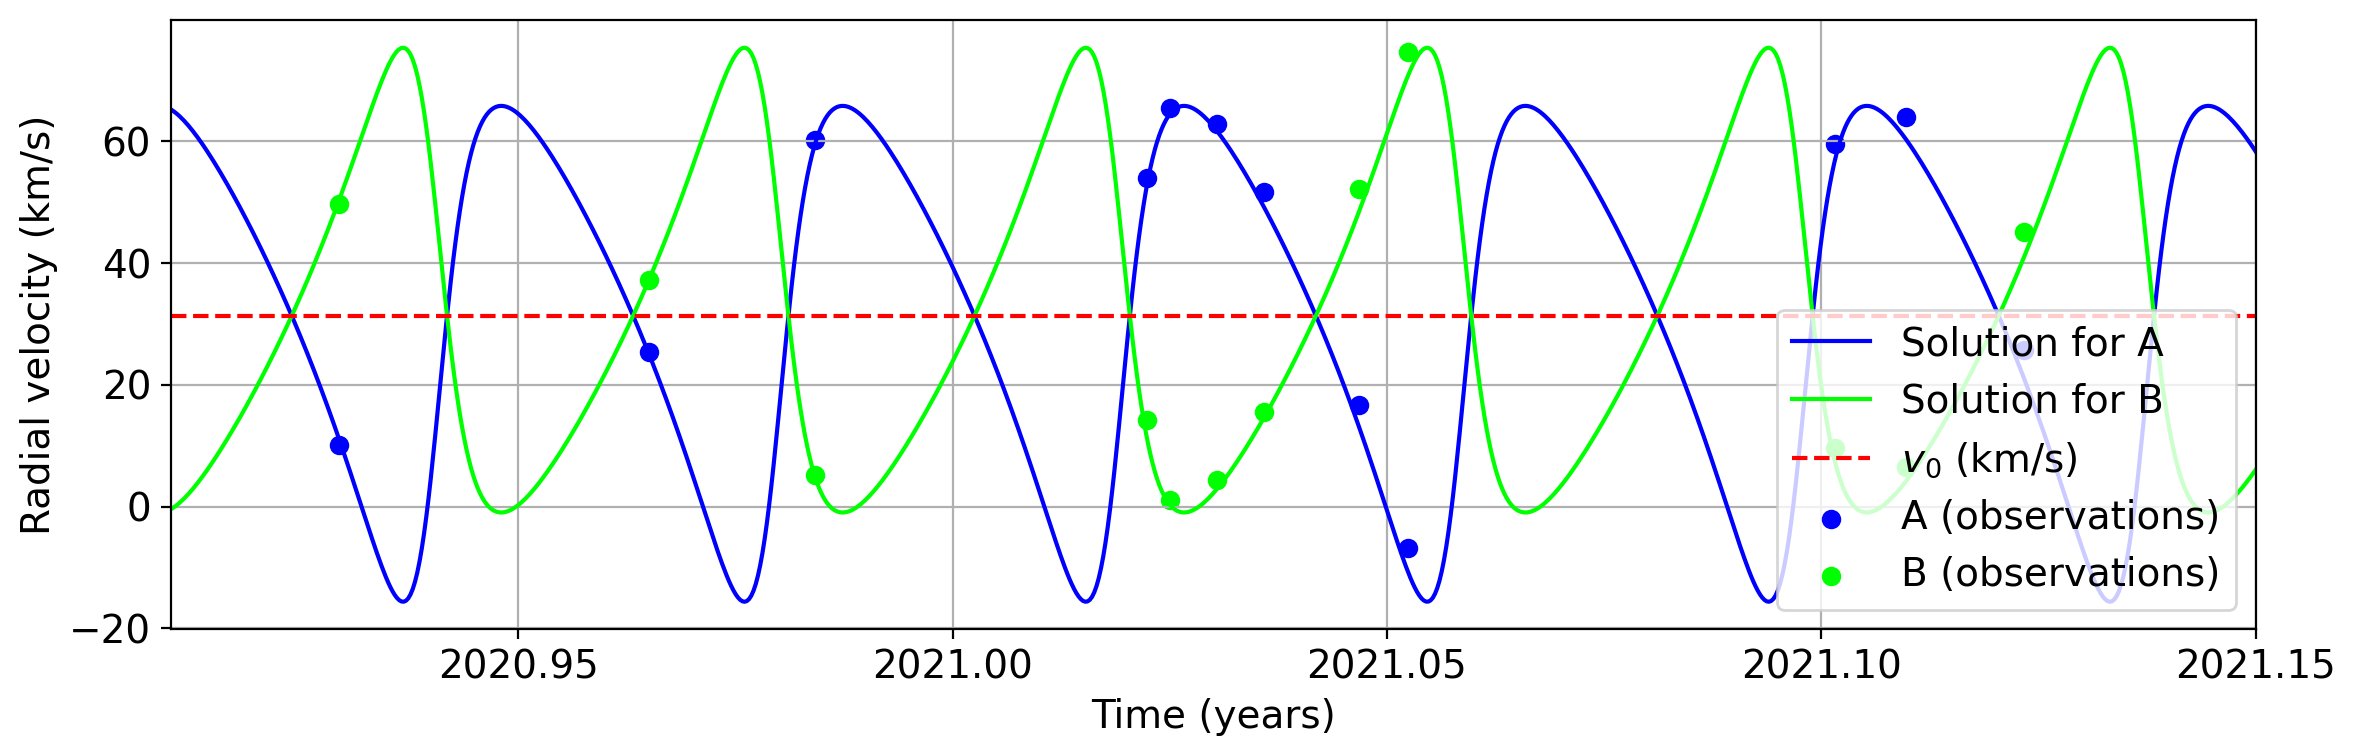

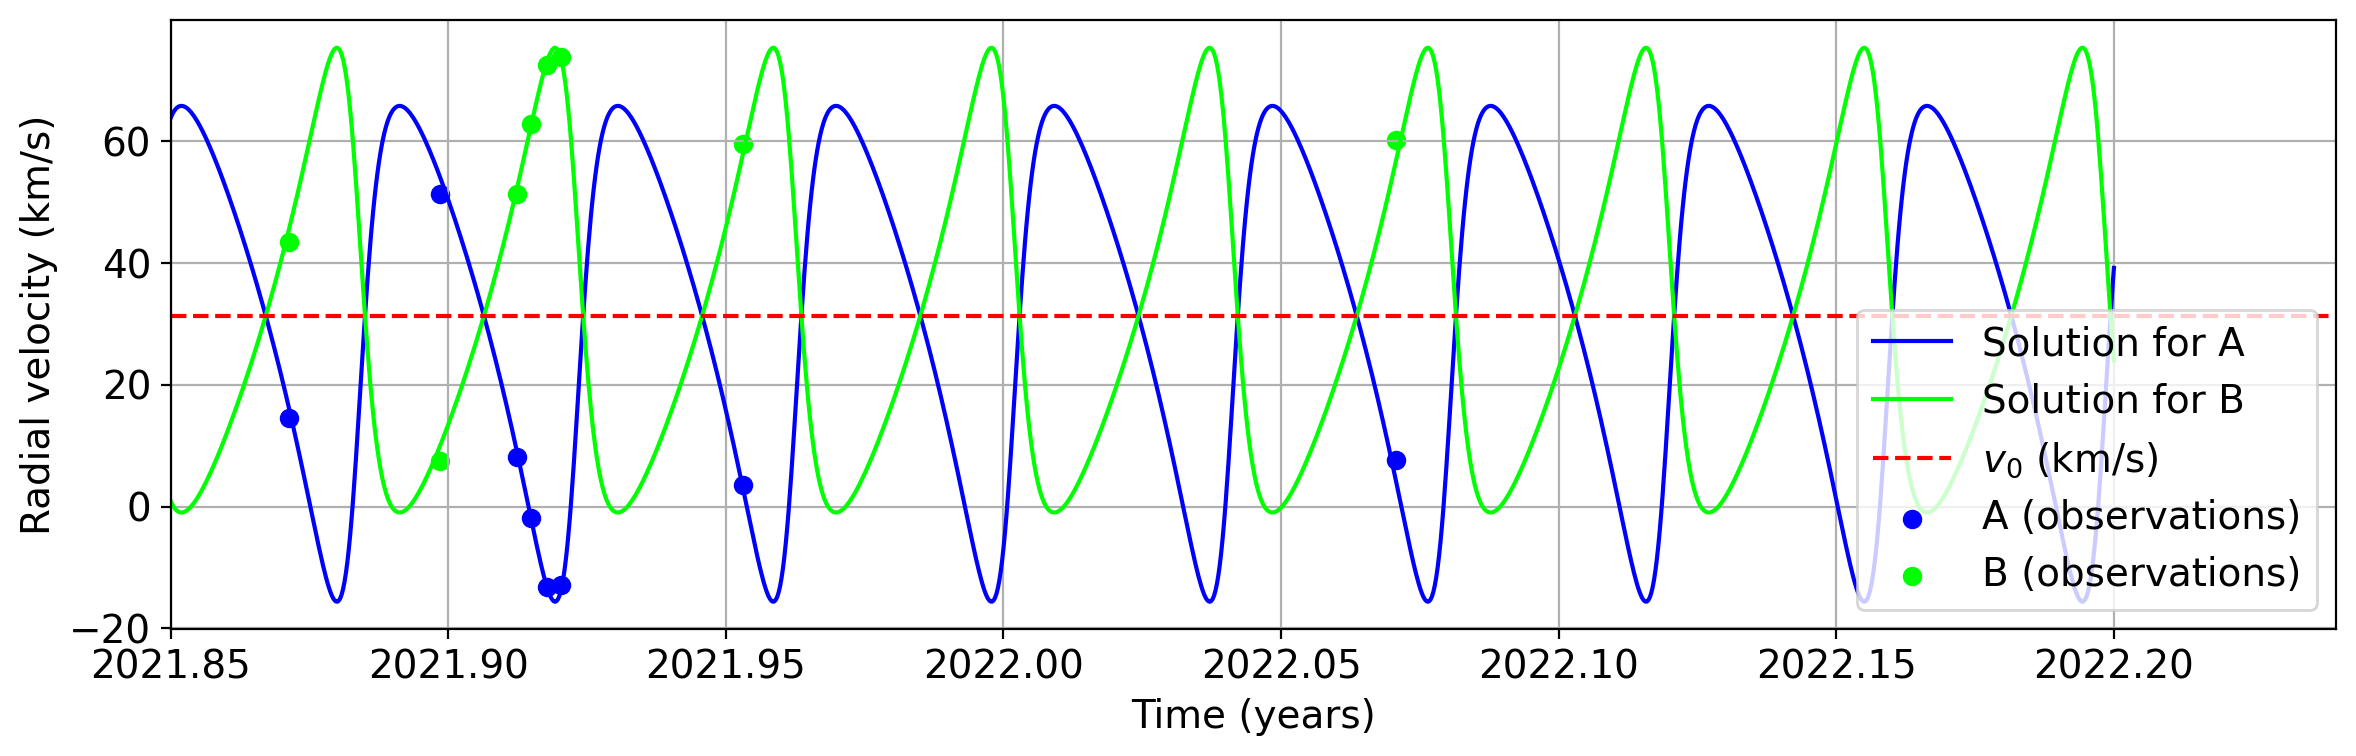

In [18]:
#Displaying radial velocity as a function of time

plt.rcParams['font.size'] = '14'

plt.figure(figsize=(12, 4), dpi=200)
plt.grid()

plt.scatter(table_vr['Time'][Type==2],table_vr['v'][Type==2],color='blue',label='A (observations)')
plt.scatter(table_vr['Time'][Type==3],table_vr['v'][Type==3],color='lime',label='B (observations)')

plt.plot(t_b,vrad_1b,color='blue',label='Solution for A')
plt.plot(t_b,vrad_2b,color='lime',label='Solution for B')

#plt.scatter(table_vr['Time'][Type==2],o_c_1,color='cyan',marker='+',label='O-C, Type 2')
#plt.scatter(table_vr['Time'][Type==3],o_c_2,color='blue',marker='+',label='O-C, Type 3')

plt.axhline(V0_b,color='red',linestyle='--',label='$v_0$ (km/s)')
plt.xlabel('Time (years)')
plt.ylabel('Radial velocity (km/s)')
plt.legend(loc='lower right')
plt.xlim(2020.91,2021.15) #limite basse en années Juliennes
plt.tight_layout()

#plt.savefig("vrad_A_APOGEE3.png")

plt.figure(figsize=(12, 4), dpi=200)
plt.grid()
plt.scatter(table_vr['Time'][Type==2],table_vr['v'][Type==2],color='blue',label='A (observations)')
plt.scatter(table_vr['Time'][Type==3],table_vr['v'][Type==3],color='lime',label='B (observations)')

plt.plot(t_b,vrad_1b,color='blue',label='Solution for A')
plt.plot(t_b,vrad_2b,color='lime',label='Solution for B')

#plt.scatter(table_vr['Time'][Type==2],o_c_1,color='cyan',marker='+',label='O-C, Type 2')
#plt.scatter(table_vr['Time'][Type==3],o_c_2,color='blue',marker='+',label='O-C, Type 3')

plt.xlabel('Time (years)')
plt.ylabel('Radial velocity (km/s)')
plt.axhline(V0_b,color='red',linestyle='--',label='$v_0$ (km/s)')
plt.legend(loc='lower right')
plt.xlim(2021.850,2022.24)#limite haute en années Juliennes
plt.tight_layout()
#plt.savefig("vrad_B_APOGEE3.png")

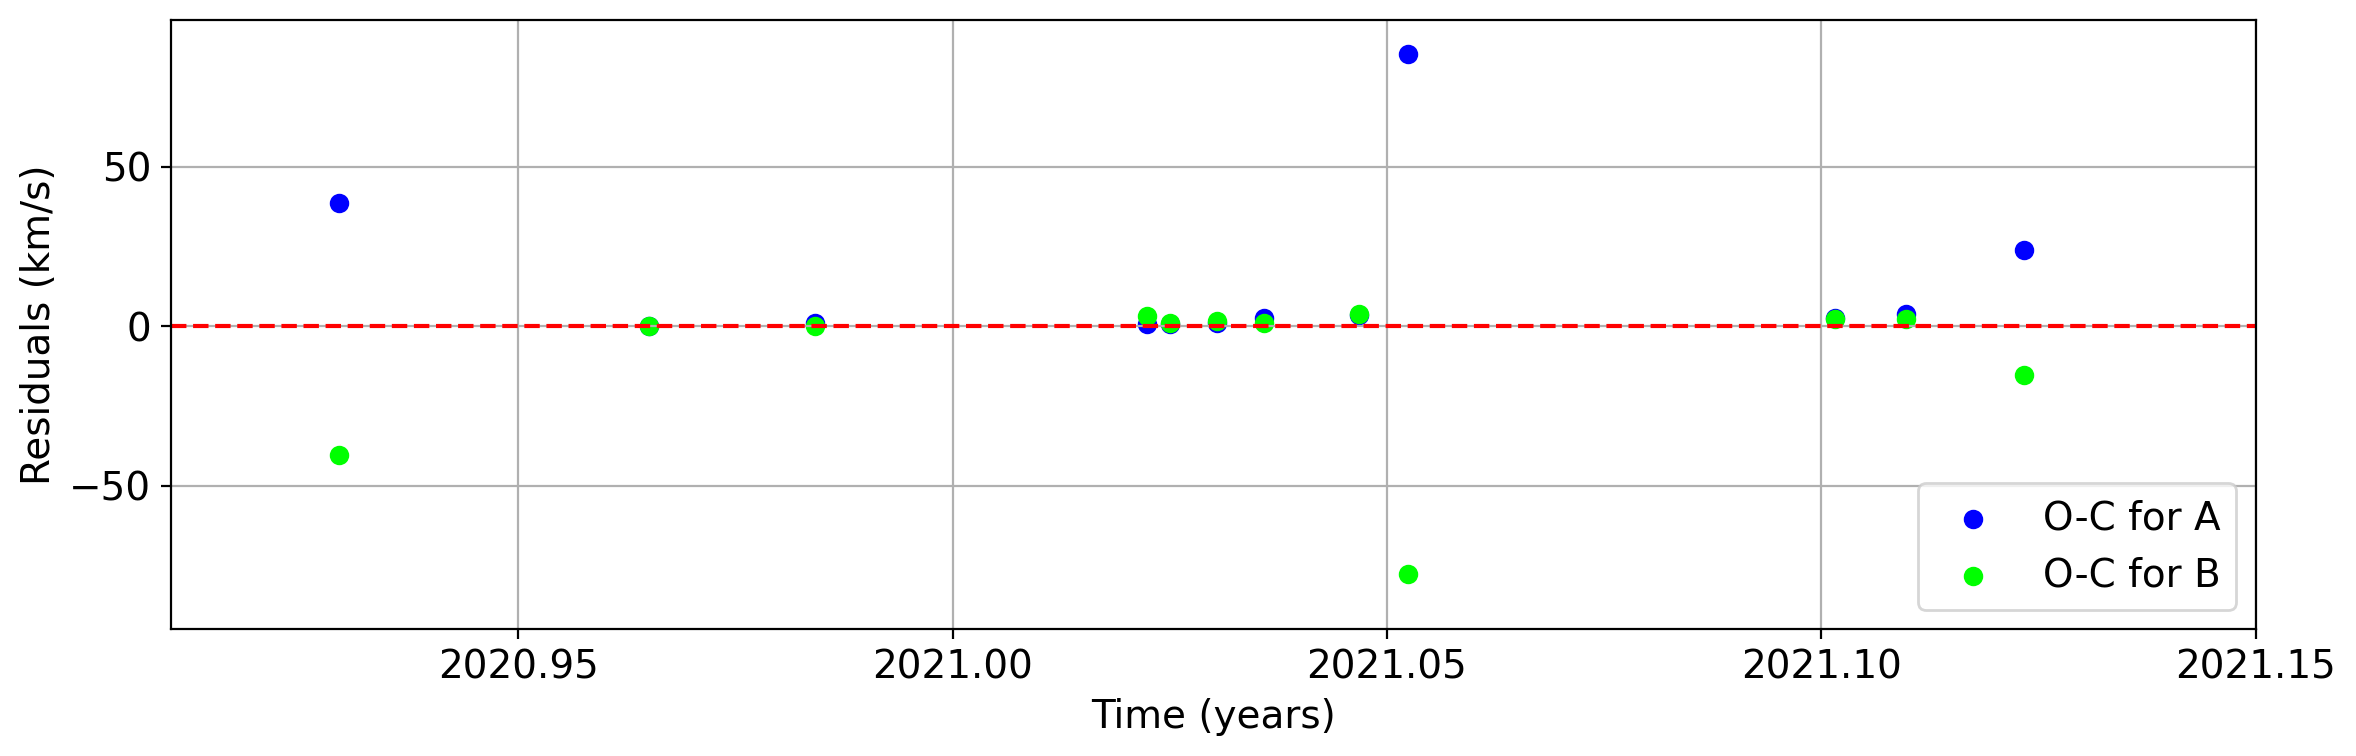

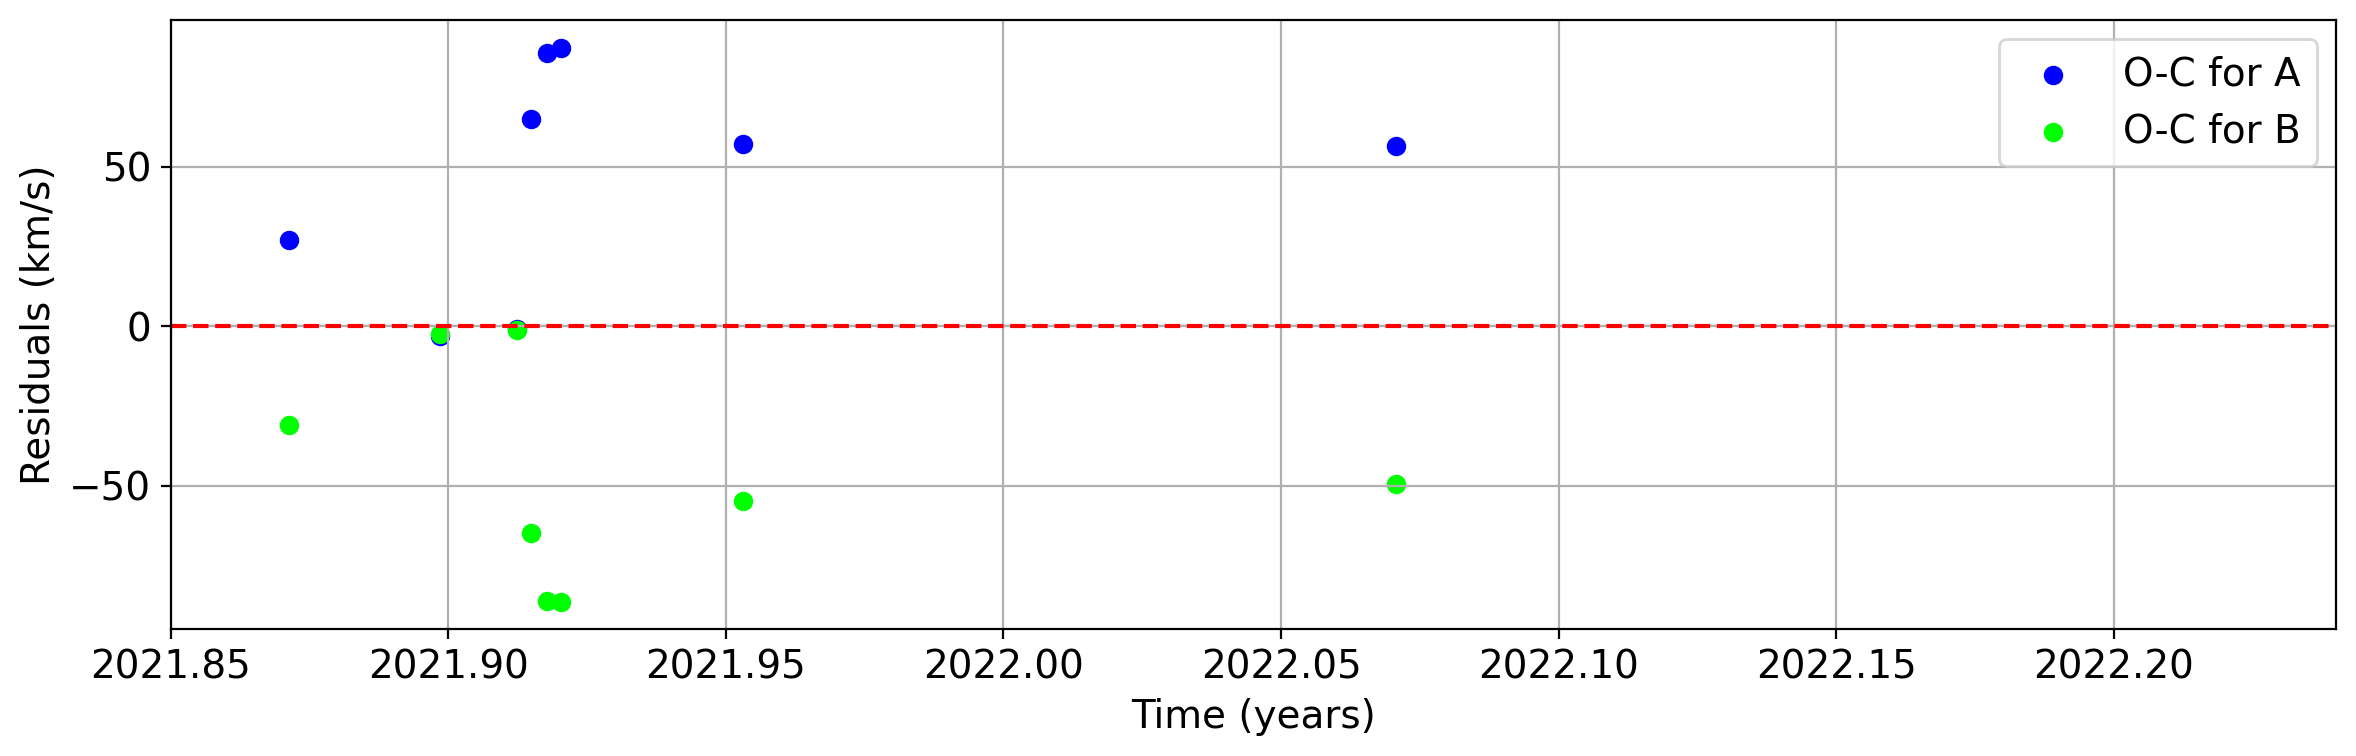

In [14]:
#Displaying 'Observed minus Computed' velocities as a function of time

plt.figure(figsize=(12, 4), dpi=200)
plt.grid()
plt.scatter(table_vr['Time'][Type==2],o_c_1,color='blue',label='O-C for A')
plt.scatter(table_vr['Time'][Type==3],o_c_2,color='lime',label='O-C for B')
plt.xlabel('Time (years)')
plt.ylabel('Residuals (km/s)')
plt.axhline(0,color='red',linestyle='--')
plt.legend(loc='lower right')
plt.xlim(2020.91,2021.15)
plt.tight_layout()
#plt.savefig("OC_A_APOGEE3.png")

plt.figure(figsize=(12, 4), dpi=200)
plt.grid()
plt.scatter(table_vr['Time'][Type==2],o_c_1,color='blue',label='O-C for A')
plt.scatter(table_vr['Time'][Type==3],o_c_2,color='lime',label='O-C for B')
plt.xlabel('Time (years)')
plt.ylabel('Residuals (km/s)')
plt.legend(loc='best')
plt.axhline(0,color='red',linestyle='--')
plt.xlim(2021.850,2022.24)
plt.tight_layout()
#plt.savefig("OC_B_APOGEE3.png")

In [15]:
phase_list=[]
for i in range(len(y_master)):
    phase = np.modf((y_master[i] - t0_b)/(P_b))[0]
    if phase < 0:
        phase = 1 + phase[phase<0]
        obs_phase = np.concatenate([phase-1, phase, phase+1])
        phase_list.append(obs_phase)
    

In [16]:
phase_list
#pour tracer le graphe: on prend la colonne du milieu
#pour tracer les vitesses théoriques en fonction des phases théoriques, on utilise une phase théorique
#(linspace) et on trace v_th avec la phase en paramètre

[]

In [17]:
#Write new pvd file containing the table

#np.savetxt('apogee_beg_lim.pvd',table_beginning,delimiter=' ', newline='\n', header='0\n0\n2000', comments='',fmt=['%d','%1.7f','%1.3f','%1.3f','%d'])

#np.savetxt('apogee_arcturus_all.pvd',table_vr,delimiter=' ', newline='\n', header='0\n0\n2000', comments='',fmt=['%d','%1.7f','%1.3f','%1.3f','%d'])
#np.savetxt('apogee_21_02_22.pvd',table_vr,delimiter=' ', newline='\n', header='0\n0\n2000', comments='',fmt=['%d','%1.7f','%1.3f','%1.3f','%d'])
#for line in table_beginning:
#    with open('apogee_beg_lim.pvd','w') as f:
#        f.write('0')
#        f.write('\n')
#        f.write('0')
#        f.write('\n')
#        f.write('2000')
#        f.write('\n')
#        f.write(tabulate(table_beginning,tablefmt="plain"))
